In [2]:
!pip install --upgrade azure-cognitiveservices-vision-computervision
!pip install pillow
!pip install azure-ai-textanalytics==5.1.0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import text2emotion as te
import cv2
import ftfy
import uuid
import nltk
import random
import IPython.display

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time


nltk.download("vader_lexicon")

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\natar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = "ab1b27f9f3fe48a6aac6b3de0224e94a"
endpoint = "https://ragul.cognitiveservices.azure.com/"


In [2]:
reviews_data = pd.read_csv("data/reviews_data.csv")
reviews_data

,rating,date,reviews,comments,id,hotel_name,Disliked,Liked,city
0,10.0,July 2019,Exceptional,Liked\n · Great little gem of a hotel and loca...,0,Prince Theatre Heritage Stay,NaN,Great little gem of a hotel and location,Bangkok
1,10.0,January 2022,Exceptional,"Liked\n · Beautiful, interesting place to stay...",0,Prince Theatre Heritage Stay,NaN,"Beautiful, interesting place to stay. Great br...",Bangkok
2,10.0,December 2019,PRINCE THEATRE Stay.,Liked\n · Everything.. I didn't book with brea...,0,Prince Theatre Heritage Stay,There is nothing I didn't like.. The place was...,Everything.. I didn't book with breakfast but ...,Bangkok
3,9.6,February 2020,Exceptional,Liked\n · A different kind of place to stay wi...,0,Prince Theatre Heritage Stay,I stayed in one of the master suites. The room...,A different kind of place to stay with a free ...,Bangkok
4,8.3,January 2020,Friendly staff and a comfortable stay,Liked\n · Staff were very helpful and friendly...,0,Prince Theatre Heritage Stay,Bathroom has a bad smell,Staff were very helpful and friendly. The room...,Bangkok
...,...,...,...,...,...,...,...,...,...
14892,1.0,July 2021,Bad,Liked\n · Late checked out before 1pm.Disliked...,24,J8 Hotel (SG Clean),We actually requested for a double bed was giv...,Late checked out before 1pm.Disliked,Singapore
14893,1.0,June 2021,Bad,Liked\n · Bad breakfastDisliked\n · The pillow...,24,J8 Hotel (SG Clean),The pillow so smelly. Ask to change but no action,Bad breakfastDisliked,Singapore
14894,5.0,June 2021,Fair,Liked\n · Front desk were very helpful. Manage...,24,J8 Hotel (SG Clean),Aircon needs to change .. cant feel the aircon .,Front desk were very helpful. Manager was grea...,Singapore
14895,1.0,June 2021,Bad,Disliked\n · The walls on the room were so poo...,24,J8 Hotel (SG Clean),The walls on the room were so poorly maintaine...,NaN,Singapore


In [3]:
sentiments=[]

sia = SentimentIntensityAnalyzer()


for review, liked, disliked in zip(reviews_data.reviews, reviews_data.Liked, reviews_data.Disliked):
    string = str(review) + " " + str(liked) + " " + str(disliked)
    if type(string) == str:
        temp=sia.polarity_scores(string)
    else:
        temp=np.nan

    sentiments.append(temp)

In [4]:
reviews_data = reviews_data.join (pd.DataFrame(sentiments))

In [ ]:
reviews_data= reviews_data[['id','hotel_name','city','rating', 'date', 'reviews', 'comments', 'Disliked',
       'Liked',  'neg', 'neu', 'pos', 'compound']]

reviews_data.to_csv("data/reviews_data_with_sentiments.csv", index=False)

In [5]:
ratings = pd.read_csv("data/ratings_data.csv")

master= reviews_data.merge(ratings.drop(["hotel_name"], axis=1), left_on=["id","city"], right_on=["value", "city"])

In [120]:
data =master.groupby(["id", "city"])[["compound", "overall"]].agg("mean")
clusters= kmeans(data[["overall", "compound"]].values, 2)


0.3810903263978726

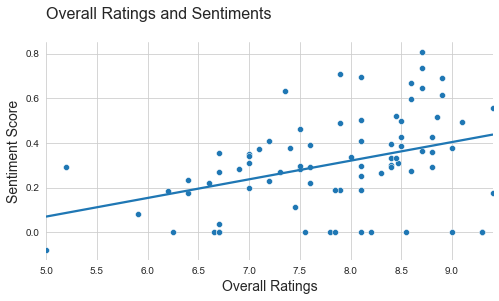

In [124]:
sns.set_style("whitegrid")
fig, ax1= plt.subplots(figsize =(8, 4))
ax1=sns.scatterplot(data=data[["overall", "compound"]], x="overall", y="compound",palette="Dark2", ax=ax1)

#ax1.legend(labels=["Good Wifi-Good Ratings", "Bad Wifi-Average Ratings", "Average Wifi-Good Ratings", "Good Wifi-Averrage Ratings"])
ax1= sns.regplot(data=data[["overall", "compound"]], x="overall", y="compound", ax=ax1, scatter=False, ci=0)
sns.despine(left=True, bottom=True)
ax1.set_title("Overall Ratings and Sentiments\n", loc="left", fontsize=16)


ax1.set_xlabel("Overall Ratings", fontsize=14)
ax1.set_ylabel("Sentiment Score",  fontsize=14)

data.overall.corr(data.compound)


<AxesSubplot:xlabel='overall', ylabel='cleanliness_r'>

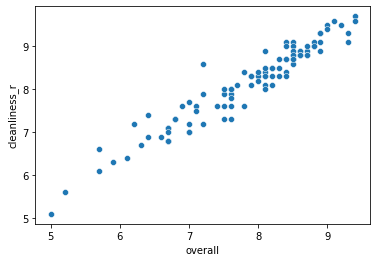

In [11]:
sns.scatterplot(x="overall", y="cleanliness_r", data=ratings)


<AxesSubplot:xlabel='overall', ylabel='Free_wifi'>

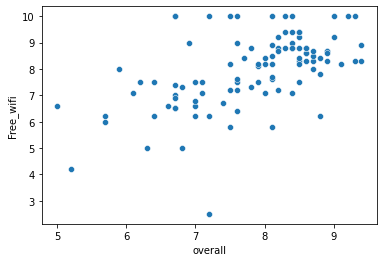

In [12]:
sns.scatterplot(x="overall", y="Free_wifi", data=ratings)


In [21]:
len(ratings[ratings["city"]=="Kulalampur"])

51

In [29]:
reviews_data.groupby(["city", "id"]).id.agg("count").groupby(["city"]).agg("mean")

city
Bangkok       158.948718
Kulalampur    170.031250
Singapore     148.045455
Name: id, dtype: float64

In [30]:
def kmeans(data, k, n=50):
    """
    parameters:
        data: a numpy matrix/array with each observations as rows
        k: no. of clusters
        n: no. of iterations
    Returns:
         clusters: A one-dimentional numpy array
    """
    choices = np.random.randint(0,len(data), size=k)
    centroids = data[choices, :]

    for i in range(n):
        distances = np.sqrt(np.sum((data[:,None,:] - centroids[None,:,:]) ** 2, axis=2))
        clusters = [np.argmin(i) for i in distances]

        centroids = []

        for j in range(k):
            centroids.append(data[clusters==np.array(j)].mean(axis=0) )

        centroids=np.concatenate([i.reshape((1,len(i))) for i in centroids])

    return clusters 

### CLustering : Wifi and overall  ratings

In [81]:
clusters= kmeans(ratings[["overall", "Free_wifi"]].values, 4)


Text(0, 0.5, 'Cleanliness')

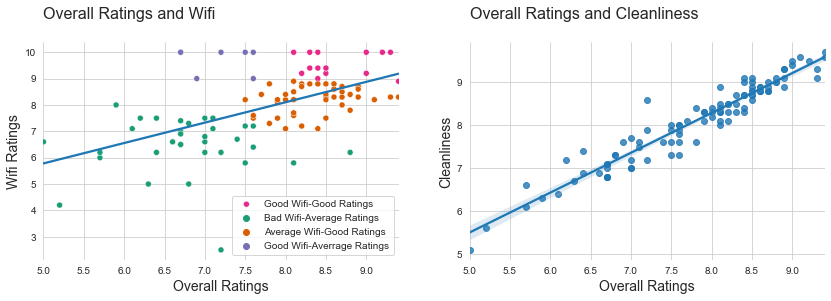

In [113]:
#c=pd.Series(clusters).map({2:"Good Wifi-Good Ratings", 1:"Good Wifi-Average Ratings", 0:"Averag Wifi-Averrage Ratings", 3:"Average Wifi-Average Ratings"})
sns.set_style("whitegrid")
fig, [ax1, ax2]= plt.subplots(figsize =(14, 4), ncols=2)
ax1=sns.scatterplot(data=ratings[["overall", "Free_wifi"]], x="overall", y="Free_wifi", hue=clusters,palette="Dark2", ax=ax1)

ax1.legend(labels=["Good Wifi-Good Ratings", "Bad Wifi-Average Ratings", "Average Wifi-Good Ratings", "Good Wifi-Averrage Ratings"])
ax1= sns.regplot(data=ratings[["overall", "Free_wifi"]], x="overall", y="Free_wifi", ax=ax1, scatter=False, ci=0)
sns.despine(left=True, bottom=True)
ax1.set_title("Overall Ratings and Wifi\n", loc="left", fontsize=16)


ax1.set_xlabel("Overall Ratings", fontsize=14)
ax1.set_ylabel("Wifi Ratings",  fontsize=14)


#fig, ax= plt.subplots(figsize =(8, 4))
sns.regplot(data=ratings[["overall", "cleanliness_r"]], x="overall", y="cleanliness_r", ax=ax2)


plt.title("Overall Ratings and Cleanliness\n", loc="left", fontsize=16)

sns.despine(left=True, bottom=True)
plt.xlabel("Overall Ratings", fontsize=14)
plt.ylabel("Cleanliness",  fontsize=14)



Text(0, 0.5, 'Cleanliness')

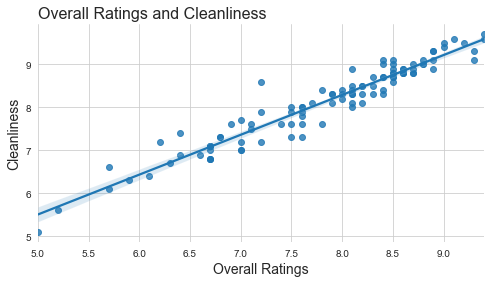

In [106]:
sns.set_style("whitegrid")
#fig, ax= plt.subplots(figsize =(8, 4))
sns.regplot(data=ratings[["overall", "cleanliness_r"]], x="overall", y="cleanliness_r", ax=ax2)


plt.title("Overall Ratings and Cleanliness", loc="left", fontsize=16)

sns.despine(left=True, bottom=True)
plt.xlabel("Overall Ratings", fontsize=14)
plt.ylabel("Cleanliness",  fontsize=14)

<AxesSubplot:xlabel='overall', ylabel='cleanliness_r'>

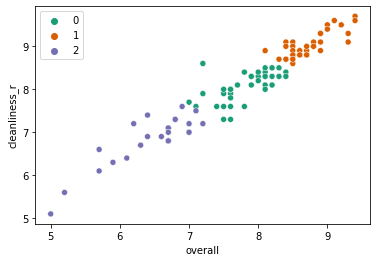

In [48]:
clusters= kmeans(ratings[["overall", "cleanliness_r"]].values, 3)

sns.scatterplot(data=ratings[["overall", "cleanliness_r"]], x="overall", y="cleanliness_r", hue=clusters,palette="Dark2")

### Ratings and Sentiments

<AxesSubplot:xlabel='overall', ylabel='compound'>

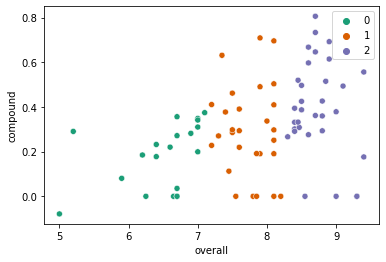

In [65]:
clusters= kmeans(data.values,  3)

sns.scatterplot(data=data, x="overall", y="compound", hue=clusters,palette="Dark2")